<a href="https://colab.research.google.com/github/souadkhailia/sales_predictions_2023/blob/main/Project_1__Part_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
# Read in the data and display the preview/summary
df = pd.read_csv('/content/drive/MyDrive/data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [92]:
# Get the number of rows (records) and columns (features)
num_rows, num_columns = df.shape
# Print the results
print(f"Number of features (columns): {num_columns}")
print(f"Number of records (rows): {num_rows}")

Number of features (columns): 12
Number of records (rows): 8523


In [93]:
# Get data type information for each feature
data_types = df.dtypes

# Count the occurrences of each data type
data_type_counts = data_types.value_counts()

# Print the results
print("There was a mixture of datatypes:")
for dtype, count in data_type_counts.items():
    print(f"{count} {dtype}")


There was a mixture of datatypes:
7 object
4 float64
1 int64


In [94]:
# the list the features of each data type
for dtype in data_type_counts.index:
    features = df.select_dtypes(include=[dtype]).columns
    if len(features) > 0:
        print(f"{len(features)} {dtype} features: {', '.join(features)}")

7 object features: Item_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type, Outlet_Type
4 float64 features: Item_Weight, Item_Visibility, Item_MRP, Item_Outlet_Sales
1 int64 features: Outlet_Establishment_Year


In [95]:
# Identify string columns
obj_cols = df.select_dtypes("object").columns
obj_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [96]:
# Obtain the value counts for all string columns
for col in obj_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


In [97]:
# Check the unique values and counts of the 'Item_Fat_Content' column
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [98]:
# Standardize the values in the Central column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':"Low Fat",'reg':'Regular','low fat':'Low Fat'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [99]:
# Checking object columns for numeric data
df.select_dtypes('object').head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1


In [100]:
# Getting the description for numeric features
description = df.describe().round(2)
description
# Limit output to min, max, 25% and 75%
description.loc[['min','25%','75%','max']]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
min,4.56,0.00,31.29,1985.0,33.29
25%,8.77,0.03,93.83,1987.0,834.25
75%,16.85,0.09,185.64,2004.0,3101.30
max,21.35,0.33,266.89,2009.0,13086.96


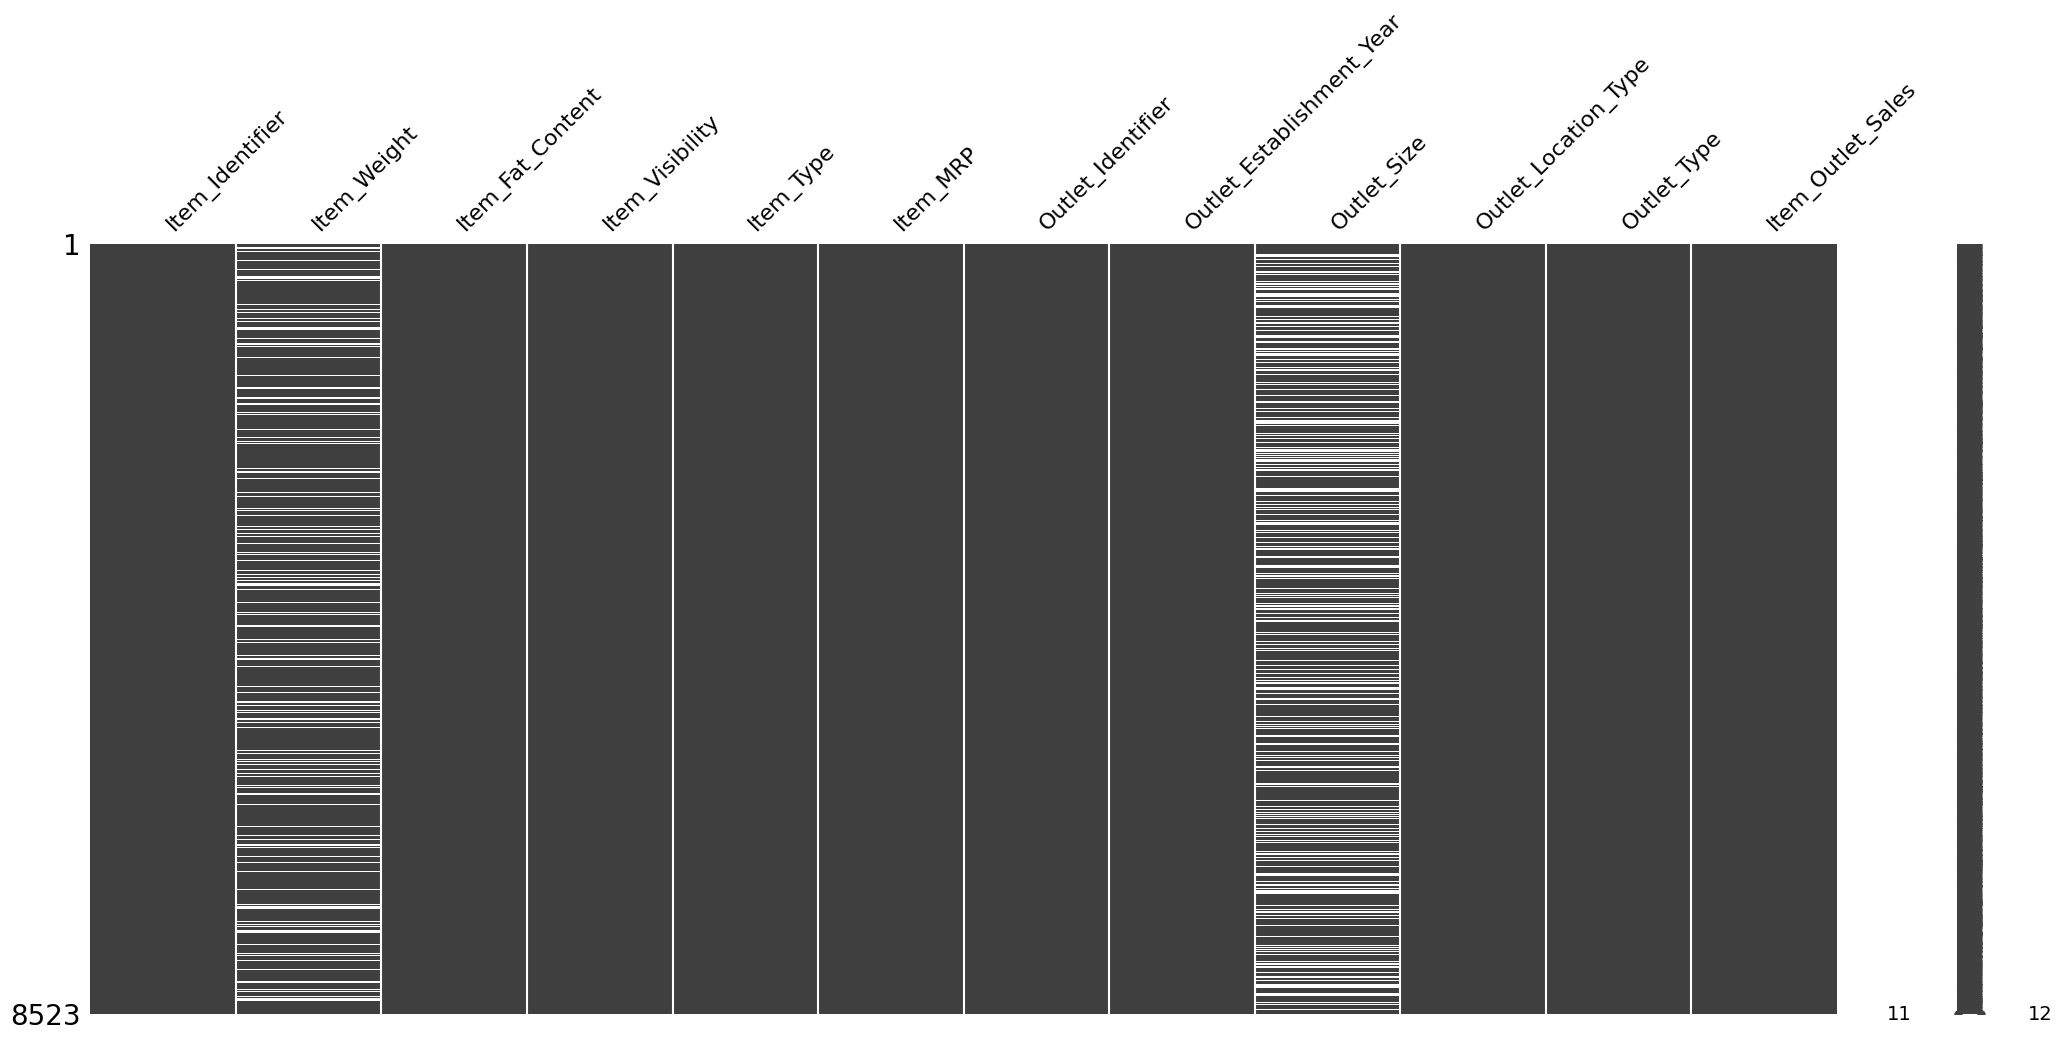

In [101]:
# Using missingno to view heatmap of NaN's
import missingno as msno
msno.matrix(df);

In [102]:
# Get the # of null values per column
null_sums = df.isna().sum()
null_sums[null_sums>0]



Item_Weight    1463
Outlet_Size    2410
dtype: int64

In [103]:
# Calculate the % of null values
null_percent = null_sums/len(df) * 100
# Show only columns with missing values
null_percent[null_percent>0]



Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

In [104]:
df[df.duplicated(keep=False)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [105]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = df.select_dtypes(include=numerics)

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Item_Weight', ylabel='Count'>

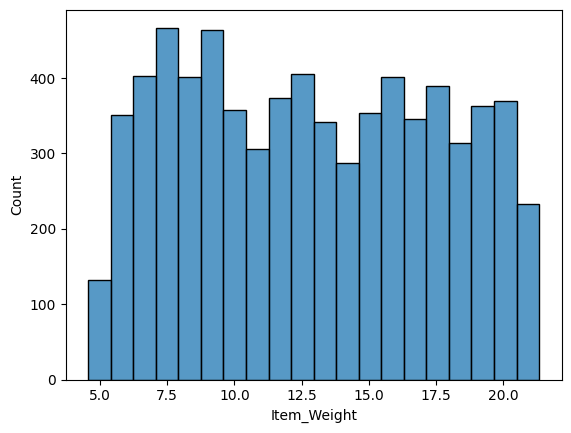

In [107]:
sns.histplot(data=num_df, x='Item_Weight', y=None, hue=None,  stat='count', bins='auto')

<Axes: xlabel='Item_Visibility', ylabel='Count'>

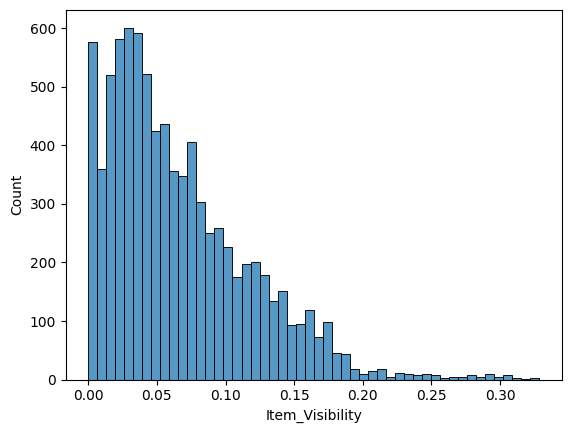

In [108]:
sns.histplot(data=num_df, x='Item_Visibility', y=None, hue=None,  stat='count', bins='auto')

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

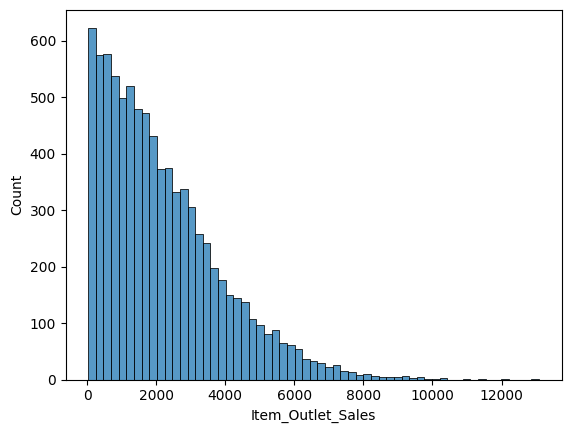

In [109]:
sns.histplot(data=num_df, x='Item_Outlet_Sales', y=None, hue=None,  stat='count', bins='auto')

<Axes: xlabel='Item_Fat_Content', ylabel='Item_Weight'>

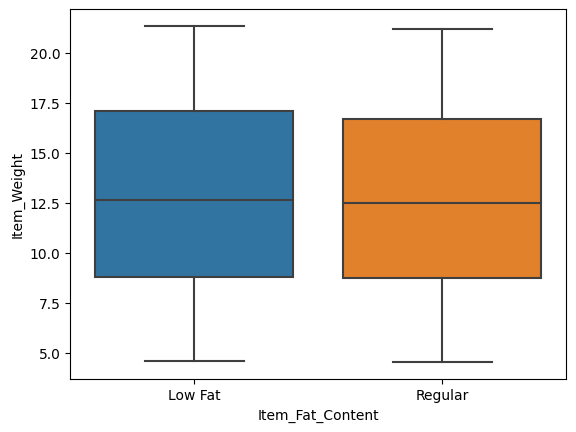

In [110]:
sns.boxplot(data=df, x='Item_Fat_Content', y='Item_Weight')

<Axes: xlabel='Outlet_Size', ylabel='Item_Weight'>

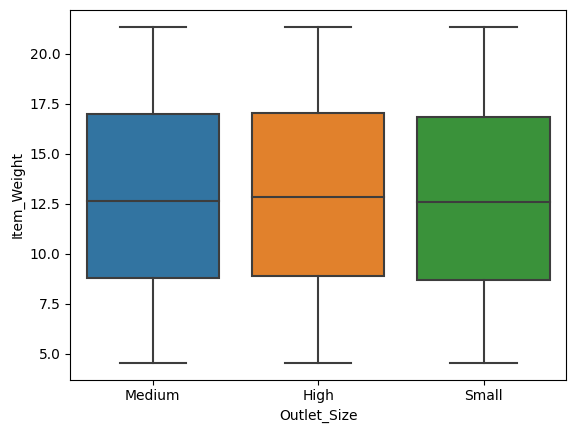

In [111]:
sns.boxplot(data=df, x='Outlet_Size', y='Item_Weight')

In [112]:
cor = num_df.corr()
cor

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


<Axes: >

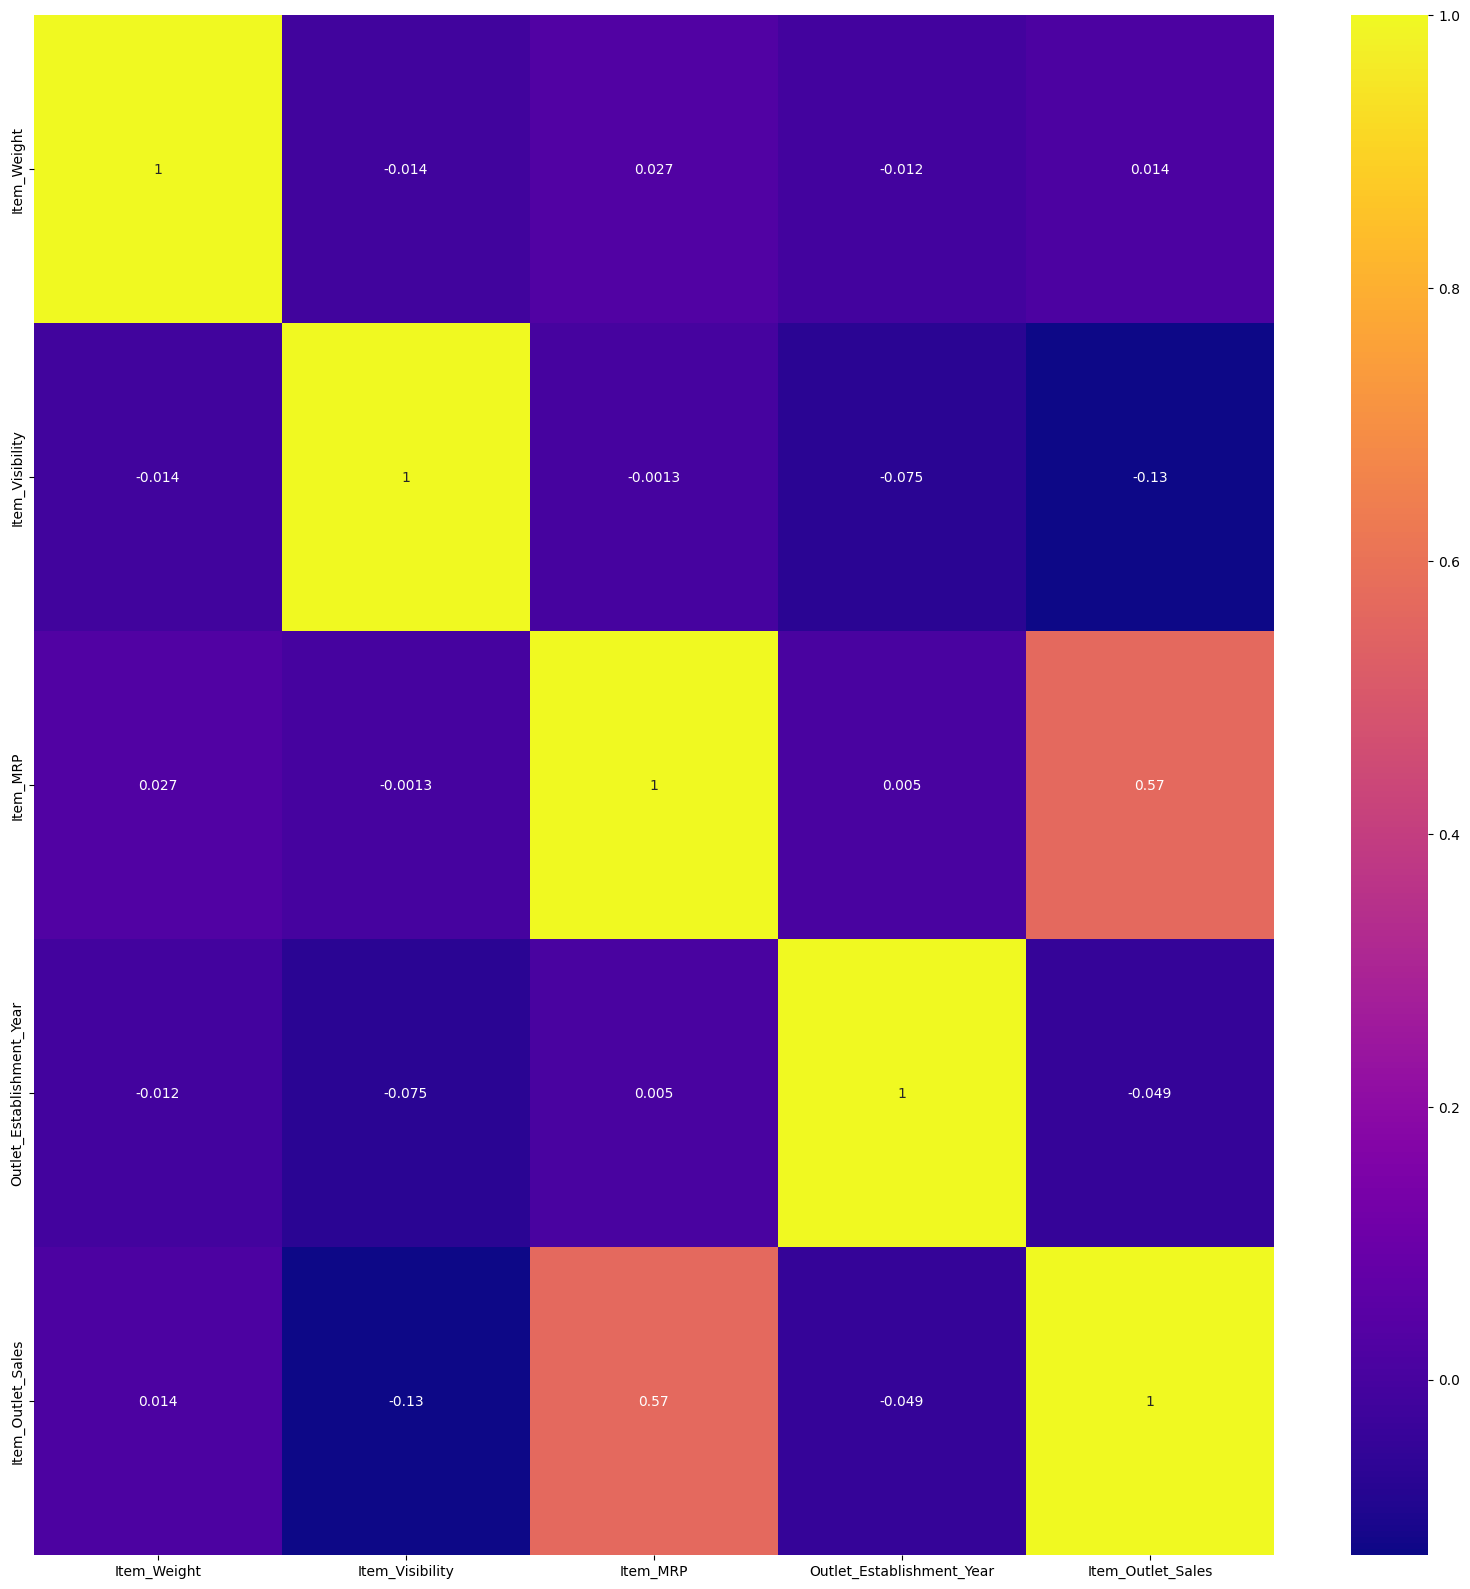

In [113]:
plt.figure(figsize=(20,20))
sns.heatmap(cor, cmap='plasma', annot=True)

In [114]:
# Copy of dataframe just for visualization and EDA
temp_df = df.copy()



In [115]:
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



In [116]:

# Get the list of categorical columns (columns with 'object' data type)
categorical_columns = temp_df.select_dtypes(include=['object']).columns
categorical_columns


Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

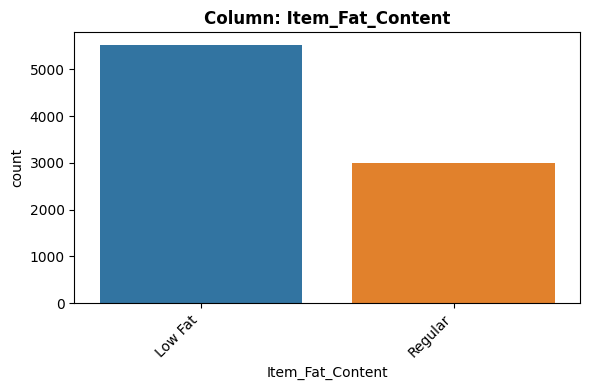

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [117]:

import matplotlib.pyplot as plt


# Test our function with the print statements
explore_categorical(temp_df, 'Item_Fat_Content');



In [118]:
def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax



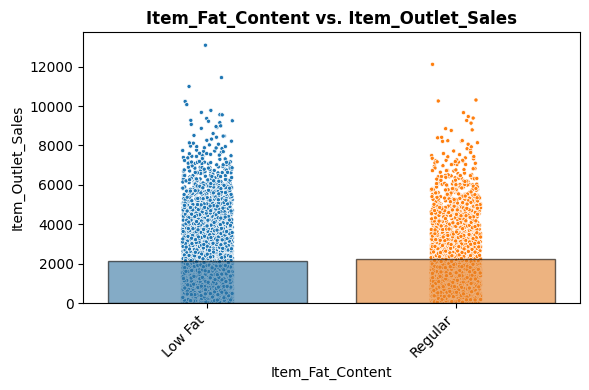

In [119]:
# Test with an order argument
fig, ax = plot_categorical_vs_target(df, x='Item_Fat_Content', fillna=False)



In [120]:
# Get the list of numerical columns (columns with int or float data types)
numerical_columns = temp_df.select_dtypes(include=['int', 'float']).columns
numerical_columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [121]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")



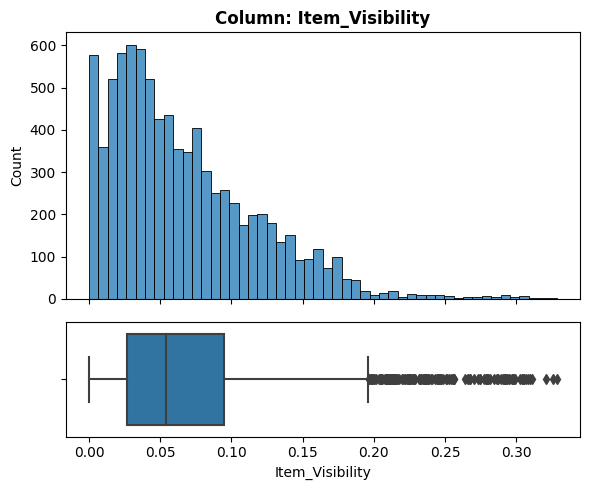

- NaN's Found: 0 (0.0%)


In [122]:
# Test the function
explore_numeric(df, "Item_Visibility")



In [123]:
# Declaring required variables
x = 'Item_Visibility'
y = "Item_Outlet_Sales"
# calculating correlation
corr = df[[x,y]].corr().round(2)
corr



,Item_Visibility,Item_Outlet_Sales
Item_Visibility,1.00,-0.13
Item_Outlet_Sales,-0.13,1.00


In [124]:
# To get the value for x vs y correlation:
r = corr.loc[x,y]
r



-0.13

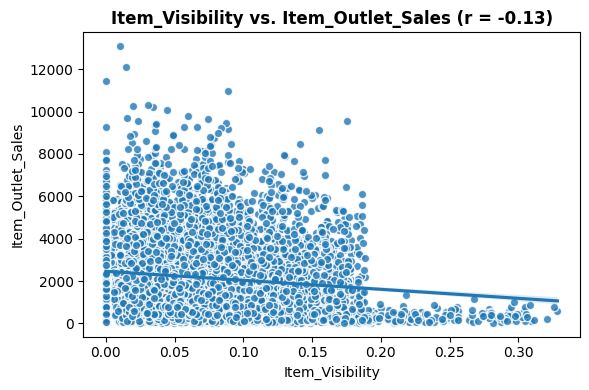

In [125]:
# Plot the data
fig, ax = plt.subplots(figsize=(6,4))
scatter_kws={'ec':'white','lw':1,'alpha':0.8}
sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
# Add the title with the correlation
ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
fig.tight_layout()



In [126]:
def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6,4)):
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax



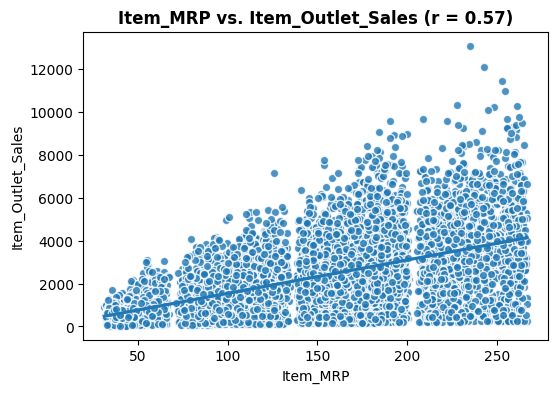

In [127]:
fig, ax = plot_numeric_vs_target(df, 'Item_MRP')



In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [129]:
df.duplicated(subset=['Item_Identifier'], keep=False)


0       True
1       True
2       True
3       True
4       True
        ... 
8518    True
8519    True
8520    True
8521    True
8522    True
Length: 8523, dtype: bool

In [130]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [131]:
# Group the data by "Outlet_Identifier" and select the "Outlet_Size" column
grouped_data = df.groupby("Outlet_Identifier")[["Outlet_Size"]].first().reset_index()
grouped_data

,Outlet_Identifier,Outlet_Size
0,OUT010,None
1,OUT013,High
2,OUT017,None
3,OUT018,Medium
4,OUT019,Small
5,OUT027,Medium
6,OUT035,Small
7,OUT045,None
8,OUT046,Small
9,OUT049,Medium


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [133]:
# Making Item_Identifier the index
df = df.set_index("Item_Identifier")
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,,,
FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, FDA15 to DRG01
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 799.0+ KB


In [135]:
# The target we are trying to predict
y = df['Item_Outlet_Sales']
# The features we will use to make the prediction
X = df.drop(columns = ['Item_Outlet_Sales'])


In [136]:
# Import the TTS from sklearn
from sklearn.model_selection import train_test_split
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [137]:
# Showing X_train and y_train have the same id's
display(X_train.head(3), y_train.head(3))



,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
Item_Identifier,,,,,,,,,,
NCG06,16.35,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
FDV57,15.25,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
FDM27,12.35,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1


Item_Identifier
NCG06     515.3292
FDV57    3056.0220
FDM27    1577.9460
Name: Item_Outlet_Sales, dtype: float64

In [138]:

# Create lists to store feature categories
num_cols=[]
ord_cols = []
cat_cols = []

# Define thresholds for classifying features
ordinal_threshold = 3  # For example, if a feature has 5 or fewer unique values, consider it ordinal

# Iterate through columns and classify features
for column in X.columns:
    unique_values = X[column].nunique()
    if unique_values == ordinal_threshold:
        ord_cols.append(column)
    elif X[column].dtype in ['int64', 'float64']:
        num_cols.append(column)
    else:
        cat_cols.append(column)

# Print the classification
print("Numerical Features:", num_cols)
print("Ordinal Features:", ord_cols)
print("Nominal Features:", cat_cols)


Numerical Features: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
Ordinal Features: ['Outlet_Size', 'Outlet_Location_Type']
Nominal Features: ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type']


In [139]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [140]:
# Null values

X_train[num_cols].isna().sum()


Item_Weight                  1107
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
dtype: int64

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Numeric features pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Scale the data with StandardScaler
])


X_train_num_tf = (numeric_pipeline.fit_transform(X_train[num_cols]))
X_test_num_tf = (numeric_pipeline.fit_transform(X_test[num_cols]))


In [142]:
X_train_num_tf

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
Item_Identifier,,,,
NCG06,0.817249,-0.712775,1.828109,1.327849
FDV57,0.556340,-1.291052,0.603369,1.327849
FDM27,-0.131512,1.813319,0.244541,0.136187
FDG24,-1.169219,-1.004931,-0.952591,0.732018
FDD05,1.528819,-0.965484,-0.336460,0.493686
...,...,...,...,...
FDY08,-0.832409,4.309657,-0.044657,0.017021
FDC41,0.639356,1.008625,-1.058907,1.089517
NCQ53,1.113736,-0.920527,1.523027,0.493686


In [143]:
from sklearn.preprocessing import OneHotEncoder

# Categorical (nominal) features pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),  # Impute missing values with 'MISSING'
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # One-hot encode with provided arguments
])


X_train_cat_tf = (categorical_pipeline.fit_transform(X_train[cat_cols]))
X_test_cat_tf = (categorical_pipeline.fit_transform(X_test[cat_cols]))

In [144]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Ordinal features pipeline
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('encoder', OrdinalEncoder(categories=[["Small", "Medium", "High"],["Tier 1","Tier 2","Tier 3"]])),
    ('scaler', StandardScaler())  # Scale the ordinal features
])

X_train_ord_tf = (ordinal_pipeline.fit_transform(X_train[ord_cols]))
X_test_ord_tf= (ordinal_pipeline.fit_transform(X_test[ord_cols]))



In [145]:
# re-combine the 3 dataframes of training data
X_train_tf = pd.concat([X_train_num_tf, X_train_ord_tf,
                               X_train_cat_tf], axis=1)
X_train_tf.info()
X_train_tf.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6392 entries, NCG06 to NCN30
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Outlet_Establishment_Year        6392 non-null   float64
 4   Outlet_Size                      6392 non-null   float64
 5   Outlet_Location_Type             6392 non-null   float64
 6   Item_Fat_Content_Low Fat         6392 non-null   float64
 7   Item_Fat_Content_Regular         6392 non-null   float64
 8   Item_Type_Baking Goods           6392 non-null   float64
 9   Item_Type_Breads                 6392 non-null   float64
 10  Item_Type_Breakfast              6392 non-null   float64
 11  Item_Type_Canned                 6392 non-null   float64
 12  Item_Type_Dairy     

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
Item_Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NCG06,0.817249,-0.712775,1.828109,1.327849,0.287374,1.084948,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
FDV57,0.556340,-1.291052,0.603369,1.327849,0.287374,1.084948,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
FDM27,-0.131512,1.813319,0.244541,0.136187,0.287374,-1.384777,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
FDG24,-1.169219,-1.004931,-0.952591,0.732018,-1.384048,-0.149914,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
FDD05,1.528819,-0.965484,-0.336460,0.493686,0.287374,-0.149914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
